In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as ks
from numpy import hstack
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
from numpy import load
# load array
X1 = load('Train1.npy')
X2 = load('Train2.npy')
y = load('Train_targets.npy')

In [4]:
def ModelPerformance(yp, yt):
    G1Tot = 0
    G1Correct = 0
    G2Tot = 0
    G2Correct = 0
    G3Tot = 0
    G3Correct = 0
    G4Tot = 0
    G4Correct = 0
    G5Tot = 0
    G5Correct = 0
    G6Tot = 0
    G6Correct = 0
    
    for i in range(len(yp)):
        if yt[i] <= 12:
            G1Tot += 1
            if yp[i] <= 12:
                G1Correct +=1
        elif yt[i] <= 35:
            G2Tot += 1
            if yp[i] > 12 and yp[i] <= 35:
                G2Correct += 1
        elif yt[i] <= 55:
            G3Tot += 1
            if yp[i] > 35 and yp[i] <= 55:
                G3Correct += 1
        elif yt[i] <= 150:
            G4Tot += 1
            if yp[i] > 55 and yp[i] <= 150:
                G4Correct += 1
        elif yt[i] <= 250:
            G5Tot += 1
            if yp[i] > 150 and yp[i] <= 250:
                G5Correct += 1
        elif yt[i] >250:
            G6Tot += 1
            if yp[i] > 250:
                G6Correct += 1
                
    MSE   = np.mean((yp-yt)**2)
    RMSE  = (MSE)**0.5
    MAPE  = np.mean(np.abs((yt-yp)/(yt)))
    OBAR  = np.mean(yt)
    IA    = 1 - np.sum((yp-yt)**2)/np.sum((np.abs(yp-OBAR) + np.abs(yt-OBAR))**2)
    G1acc = G1Correct/G1Tot * 100
    G2acc = G2Correct/G2Tot * 100
    G3acc = G3Correct/G3Tot * 100
    G4acc = G4Correct/G4Tot * 100
    G5acc = G5Correct/G5Tot * 100
    G6acc = G6Correct/G6Tot * 100
    Wacc  = ((G1acc*G1Correct)+(G2acc*G2Correct)+(G3acc*G3Correct)+(G4acc*G4Correct)+(G5acc*G5Correct)+(G6acc*G6Correct))/(len(yp))
    
    return [G1acc, G2acc, G3acc, G4acc, G5acc, G6acc, Wacc]



def build_CNN(p_size, strd, act, dpt, X1, X2):
    in1 = Input(shape=(X1.shape[1], X1.shape[2]))

    cnnx = Conv1D(filters=16, kernel_size= 50, strides = strd, activation=act)(in1)
#     cnnx = MaxPooling1D(pool_size=1)(cnnx)
    cnnx = Dropout(dpt)(cnnx) 

    cnnx = BatchNormalization()(cnnx)
    cnnx = Conv1D(filters=20, kernel_size= 30, strides = strd, activation=act)(cnnx)
#     cnnx = MaxPooling1D(pool_size= 1)(cnnx)
    cnnx = Dropout(dpt)(cnnx) 

    cnnx = BatchNormalization()(cnnx)
    cnnx = Conv1D(filters=32, kernel_size= 16, strides = strd, activation=act)(cnnx)
#     cnnx = MaxPooling1D(pool_size=1)(cnnx)
    cnnx = Dropout(dpt)(cnnx) 

    cnnx = BatchNormalization()(cnnx)
    cnnx = Conv1D(filters=64, kernel_size=  8, strides = strd, activation=act)(cnnx)
    cnnx = MaxPooling1D(pool_size=p_size)(cnnx)
    cnnx = Dropout(dpt)(cnnx)

    cnnx = BatchNormalization()(cnnx)
    cnnx = Conv1D(filters=128, kernel_size= 4, strides = strd, activation=act)(cnnx)
    cnnx = MaxPooling1D(pool_size=p_size)(cnnx)
    cnnx = Dropout(dpt)(cnnx)

    cnnx = BatchNormalization()(cnnx)
    cnnx = Conv1D(filters=256, kernel_size= 2, strides = strd, activation=act)(cnnx)
    cnnx = MaxPooling1D(pool_size=p_size)(cnnx)
    cnnx = Dropout(dpt)(cnnx)

    cnnx = Flatten()(cnnx)

    in2 = Input(shape=(X2.shape[1]))
    ffnnx = Dense(50, activation = 'sigmoid')(in2)

    mergex = concatenate([cnnx,ffnnx])
    densex = Dense(30, activation=act)(mergex)
    outputx = Dense(1)(densex)

    modelX = Model(inputs=[in1, in2], outputs=outputx)
    modelX.compile(optimizer='adam', loss='mse', metrics = ['MeanAbsolutePercentageError', 'RootMeanSquaredError'])
    return modelX


print('CNN MODEL')
p_size = 2
strd = 1

# Optimise:
act = 'swish'
dpt = 0.2

model_CNN = build_CNN(p_size,strd,'swish',dpt,X1,X2)
model_CNN.summary()

CNN MODEL
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 121, 6)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 72, 16)       4816        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 72, 16)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 72, 16)       64          dropout[0][0]                    
____________________________________________________________________________________

In [9]:


################################# ACTIVATION OPTIMISATION ############################

# Baseline CNN
train_idx = 12000 # 80% of data to
EPOCHS = 1000
BATCH = 256 
early_stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights = True, 
                                            min_delta = 5, verbose=2)
p_size = 2
strd = 1
dpt = 0.2

SimCount = 10
SimSaver = np.zeros((3,SimCount, 9)) # RMSE, MAPE, Class 1%, Class 2%, Class 3%, Class 4%, Class 5%, Class 6%, Weighted % - 9 columns

Activations = ['relu','selu','swish']


for j in range(len(Activations)):
    act = Activations[j]
    for i in range(SimCount):
        # RANDOMISING DATA
        ###############################################################
        randind = np.arange(len(y))
        np.random.shuffle(randind)
        tempX1 = X1[randind]
        tempX2 = X2[randind]
        tempy1 = y[randind]

        # Training Data
        x1 = tempX1[0:train_idx]
        x2 = tempX2[0:train_idx]
        y1 = tempy1[0:train_idx]

        # Testing Data
        testX1 = tempX1[train_idx::]
        testX2 = tempX2[train_idx::]
        testy = tempy1[train_idx::]
        ################################################################

        # Create Model
        model_CNN = build_CNN(p_size, strd, act, dpt, X1, X2)

        # Fit Model
        mCNN_hist = model_CNN.fit([x1,x2], y1, epochs=EPOCHS,validation_split=0.15, verbose=0, callbacks = [early_stop], batch_size=BATCH, shuffle = True)

        # Evaluate Model
        MSE_save, RMSE_save, MAPE_save =  model_CNN.evaluate([testX1,testX2],testy)
        y_predict_CNN = model_CNN.predict([testX1,testX2])

        # Append All Relevant Data To Matrix for Post Processing
        results = ModelPerformance(y_predict_CNN, testy)

        SimSaver[j,i,0] = RMSE_save
        SimSaver[j,i,1] = MAPE_save
        SimSaver[j,i,2] = results[0]
        SimSaver[j,i,3] = results[1]
        SimSaver[j,i,4] = results[2]
        SimSaver[j,i,5] = results[3]
        SimSaver[j,i,6] = results[4]
        SimSaver[j,i,7] = results[5]
        SimSaver[j,i,8] = results[6]


from numpy import save
# save('CNN_OptAct.npy', SimSaver)

           
################################# DROPOUT OPTIMISATION ############################

# Baseline CNN
train_idx = 12000 # 80% of data to
EPOCHS = 1000
BATCH = 256 
early_stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights = True, 
                                            min_delta = 5, verbose=2)
p_size = 2
strd = 1
act = 'swish' # This is in anticipation

SimCount = 10
SimSaver = np.zeros((3,SimCount, 9)) # RMSE, MAPE, Class 1%, Class 2%, Class 3%, Class 4%, Class 5%, Class 6%, Weighted % - 9 columns

Dropouts = [0.05, 0.1, 0.2]


for j in range(len(Dropouts)):
    dpt = Dropouts[j]
    for i in range(SimCount):
        # RANDOMISING DATA
        ###############################################################
        randind = np.arange(len(y))
        np.random.shuffle(randind)
        tempX1 = X1[randind]
        tempX2 = X2[randind]
        tempy1 = y[randind]

        # Training Data
        x1 = tempX1[0:train_idx]
        x2 = tempX2[0:train_idx]
        y1 = tempy1[0:train_idx]

        # Testing Data
        testX1 = tempX1[train_idx::]
        testX2 = tempX2[train_idx::]
        testy = tempy1[train_idx::]
        ################################################################

        # Create Model
        model_CNN = build_CNN(p_size, strd, act, dpt, X1, X2)

        # Fit Model
        mCNN_hist = model_CNN.fit([x1,x2], y1, epochs=EPOCHS,validation_split=0.15, verbose=0, callbacks = [early_stop], batch_size=BATCH, shuffle = True)

        # Evaluate Model
        MSE_save, RMSE_save, MAPE_save =  model_CNN.evaluate([testX1,testX2],testy)
        y_predict_CNN = model_CNN.predict([testX1,testX2])

        # Append All Relevant Data To Matrix for Post Processing
        results = ModelPerformance(y_predict_CNN, testy)

        SimSaver[j,i,0] = RMSE_save
        SimSaver[j,i,1] = MAPE_save
        SimSaver[j,i,2] = results[0]
        SimSaver[j,i,3] = results[1]
        SimSaver[j,i,4] = results[2]
        SimSaver[j,i,5] = results[3]
        SimSaver[j,i,6] = results[4]
        SimSaver[j,i,7] = results[5]
        SimSaver[j,i,8] = results[6]

# save('CNN_OptDPT.npy', SimSaver)



Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
111/111 [==============================] - 1s 5ms/step - loss: 792.8760 - mean_absolute_percentage_error: 35.0108 - root_mean_squared_error: 28.1727
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
111/111 [==============================] - 0s 4ms/step - loss: 736.3530 - mean_absolute_percentage_error: 37.9931 - root_mean_squared_error: 27.1075
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
111/111 [==============================] - 0s 4ms/step - loss: 739.4010 - mean_absolute_percentage_error: 35.9653 - root_mean_squared_error: 27.2114
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
111/111 [==============================] - 1s 5ms/step - loss: 726.2369 - mean_absolute_percentage_error: 34.0286 - root_mean_squared_error: 26.9401
Restoring model weights from the end of the best epoch.
Epoch 00118:

111/111 [==============================] - 1s 5ms/step - loss: 666.3496 - mean_absolute_percentage_error: 32.1875 - root_mean_squared_error: 25.8386
Restoring model weights from the end of the best epoch.
Epoch 00151: early stopping
111/111 [==============================] - 1s 5ms/step - loss: 648.4875 - mean_absolute_percentage_error: 32.2003 - root_mean_squared_error: 25.3714
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
111/111 [==============================] - 1s 5ms/step - loss: 701.1857 - mean_absolute_percentage_error: 30.1827 - root_mean_squared_error: 26.4643
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
111/111 [==============================] - 1s 5ms/step - loss: 739.2021 - mean_absolute_percentage_error: 32.5618 - root_mean_squared_error: 27.1897
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
111/111 [==============================] - 1s 5ms/step - loss: 728.2

In [59]:
# Optimal CNN
EPOCHS = 1000
BATCH = 256 
early_stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights = True, 
                                            min_delta = 5, verbose=2)
p_size = 2
strd = 1
dpt = 0.2
act = 'swish'


# RANDOMISING DATA
###############################################################
randind = np.arange(len(y))
np.random.shuffle(randind)
tempX1 = X1[randind]
tempX2 = X2[randind]
tempy1 = y[randind]

# Training Data
x1 = tempX1
x2 = tempX2
y1 = tempy1

################################################################

# Create Model
model_CNN = build_CNN(p_size, strd, act, dpt, X1, X2)

# Fit Model
mCNN_hist = model_CNN.fit([x1,x2], y1, epochs=EPOCHS,validation_split=0.15, verbose=2, callbacks = [early_stop], batch_size=BATCH, shuffle = True)


Epoch 1/50
52/52 - 7s - loss: 2600.6384 - mean_absolute_percentage_error: 73.9879 - root_mean_squared_error: 51.0846 - val_loss: 2254.0952 - val_mean_absolute_percentage_error: 46.4734 - val_root_mean_squared_error: 48.7140
Epoch 2/50
52/52 - 6s - loss: 1514.0790 - mean_absolute_percentage_error: 63.2026 - root_mean_squared_error: 38.9396 - val_loss: 2009.8972 - val_mean_absolute_percentage_error: 43.0278 - val_root_mean_squared_error: 46.0521
Epoch 3/50
52/52 - 6s - loss: 1366.7723 - mean_absolute_percentage_error: 59.3982 - root_mean_squared_error: 37.0174 - val_loss: 2027.6484 - val_mean_absolute_percentage_error: 41.2635 - val_root_mean_squared_error: 46.3017
Epoch 4/50
52/52 - 6s - loss: 1282.1456 - mean_absolute_percentage_error: 56.5298 - root_mean_squared_error: 35.7756 - val_loss: 1598.8209 - val_mean_absolute_percentage_error: 39.5602 - val_root_mean_squared_error: 41.1234
Epoch 5/50
52/52 - 6s - loss: 1232.2410 - mean_absolute_percentage_error: 55.1217 - root_mean_squared_er

Epoch 38/50
52/52 - 6s - loss: 613.3250 - mean_absolute_percentage_error: 36.7916 - root_mean_squared_error: 24.7781 - val_loss: 705.0583 - val_mean_absolute_percentage_error: 31.0828 - val_root_mean_squared_error: 27.3072
Epoch 39/50
52/52 - 6s - loss: 623.9418 - mean_absolute_percentage_error: 37.2386 - root_mean_squared_error: 24.9803 - val_loss: 740.2955 - val_mean_absolute_percentage_error: 31.5407 - val_root_mean_squared_error: 27.6913
Epoch 40/50
52/52 - 6s - loss: 619.9293 - mean_absolute_percentage_error: 36.9607 - root_mean_squared_error: 24.8790 - val_loss: 680.0200 - val_mean_absolute_percentage_error: 35.3312 - val_root_mean_squared_error: 26.6513
Epoch 41/50
52/52 - 6s - loss: 603.9279 - mean_absolute_percentage_error: 36.5404 - root_mean_squared_error: 24.5557 - val_loss: 691.3802 - val_mean_absolute_percentage_error: 31.5130 - val_root_mean_squared_error: 26.8587
Epoch 42/50
52/52 - 6s - loss: 579.5782 - mean_absolute_percentage_error: 36.1805 - root_mean_squared_error:

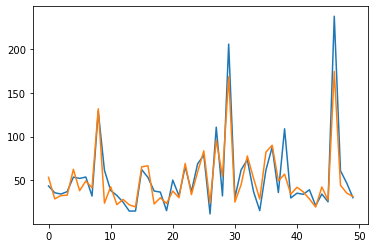

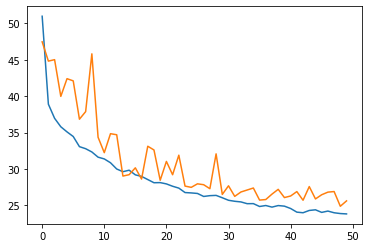

In [60]:
# Visualising Performance
start = 50
stop = start + 50

y_pred = model_CNN.predict([x1,x2])

plt.figure()
plt.plot(y1[start:stop])
plt.plot(y_pred[start:stop])



plt.figure()
plt.plot(np.sqrt(mCNN_hist.history['loss']))
plt.plot(np.sqrt(mCNN_hist.history['val_loss']))

In [61]:
# from numpy import load
# # load array
# X1t = load('Test1.npy')
# X2t = load('Test2.npy')
# y_predict_CNN_submit = model_CNN.predict([X1t,X2t])